In [ ]:
!pip3 install xgboost
!pip3 install tensorflow
!pip3 install catboost

In [ ]:
!pip3

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot


from sklearn.model_selection import train_test_split, TimeSeriesSplit, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from catboost import CatBoostClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Process Data

In [20]:
PAMAP_PARQUET  = '../../data/features/pamapv1.parquet'
pamap = pd.read_parquet(PAMAP_PARQUET)
pamap.head()

,0,54,1,2,3,4,5,6,7,8,...,44,45,46,47,48,49,50,51,52,53
0,109,1970-01-01 00:00:31,24,139.0,24.910937,-8.774862,2.921167,2.307146,-8.836571,2.969285,...,0.025054,0.072855,0.327494,-44.677669,-7.026946,3.250370,0.555624,-0.316755,0.718974,-0.268680
1,109,1970-01-01 00:00:32,24,138.0,24.937500,-8.884371,3.639173,2.511493,-8.938693,3.706951,...,0.004657,-0.017115,0.011002,-45.354818,-3.942657,2.595037,0.544582,-0.304127,0.717182,-0.310576
2,109,1970-01-01 00:00:33,24,138.0,24.901250,-7.953692,4.918869,1.920328,-8.051530,4.957867,...,0.251467,-0.058381,-0.167615,-44.676414,-7.139982,3.829399,0.530612,-0.356835,0.695447,-0.324372
3,109,1970-01-01 00:00:34,24,138.0,24.937500,-6.550635,10.524657,0.379089,-6.833505,10.539075,...,-0.264943,-0.043607,0.077041,-41.828461,-15.475105,9.590448,0.485194,-0.476597,0.661950,-0.308362
4,109,1970-01-01 00:00:35,24,138.0,24.937500,-2.638427,8.896337,-2.473392,-2.795023,9.151476,...,0.260470,-0.071397,-0.150778,-39.629503,-19.076338,12.213491,0.469625,-0.529871,0.628705,-0.304908


In [10]:
pamap.shape

(27372, 23)

Cluster 0: Relaxation
1, 2, 3, 4. 7, 12, 13

Cluster 1: Focus
10, 11

Cluster 3: Physical
5, 6, 16, 17, 18, 19, 20, 24

Remove: 9

In [22]:
cluster_mapping = {
    0: [1, 2, 3, 4, 7, 12, 13],
    1: [10, 11],
    2: [5, 6, 16, 17, 18, 19, 20, 24]
}

pamap['cluster'] = pamap[1].map({value: key for key, values in cluster_mapping.items() for value in values})
pamap = pamap[pamap[1] != 9]
pamap['cluster'] = pamap['cluster'].astype(int)
pamap = pamap.drop(columns=[1]) # drop activity ID column
pamap.head()

/var/folders/dk/zhw4_3kn6cb029559dwjrmt40000gn/T/ipykernel_85607/2641310732.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pamap['cluster'] = pamap['cluster'].astype(int)


,0,54,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,cluster
0,109,1970-01-01 00:00:31,139.0,24.910937,-8.774862,2.921167,2.307146,-8.836571,2.969285,2.242165,...,0.072855,0.327494,-44.677669,-7.026946,3.250370,0.555624,-0.316755,0.718974,-0.268680,2
1,109,1970-01-01 00:00:32,138.0,24.937500,-8.884371,3.639173,2.511493,-8.938693,3.706951,2.457878,...,-0.017115,0.011002,-45.354818,-3.942657,2.595037,0.544582,-0.304127,0.717182,-0.310576,2
2,109,1970-01-01 00:00:33,138.0,24.901250,-7.953692,4.918869,1.920328,-8.051530,4.957867,1.866055,...,-0.058381,-0.167615,-44.676414,-7.139982,3.829399,0.530612,-0.356835,0.695447,-0.324372,2
3,109,1970-01-01 00:00:34,138.0,24.937500,-6.550635,10.524657,0.379089,-6.833505,10.539075,0.278329,...,-0.043607,0.077041,-41.828461,-15.475105,9.590448,0.485194,-0.476597,0.661950,-0.308362,2
4,109,1970-01-01 00:00:35,138.0,24.937500,-2.638427,8.896337,-2.473392,-2.795023,9.151476,-2.623773,...,-0.071397,-0.150778,-39.629503,-19.076338,12.213491,0.469625,-0.529871,0.628705,-0.304908,2


In [12]:
pamap['cluster'].value_counts()

cluster
0    12239
2    10646
1     3650
Name: count, dtype: int64

<Axes: xlabel='54', ylabel='3838'>

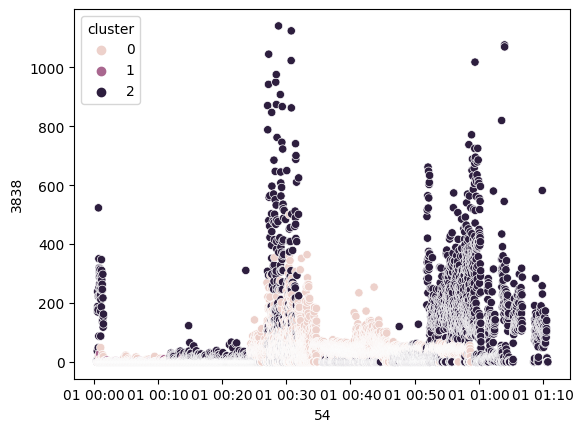

In [17]:
sns.scatterplot(data=pamap, x=54, y=3838, hue = 'cluster')

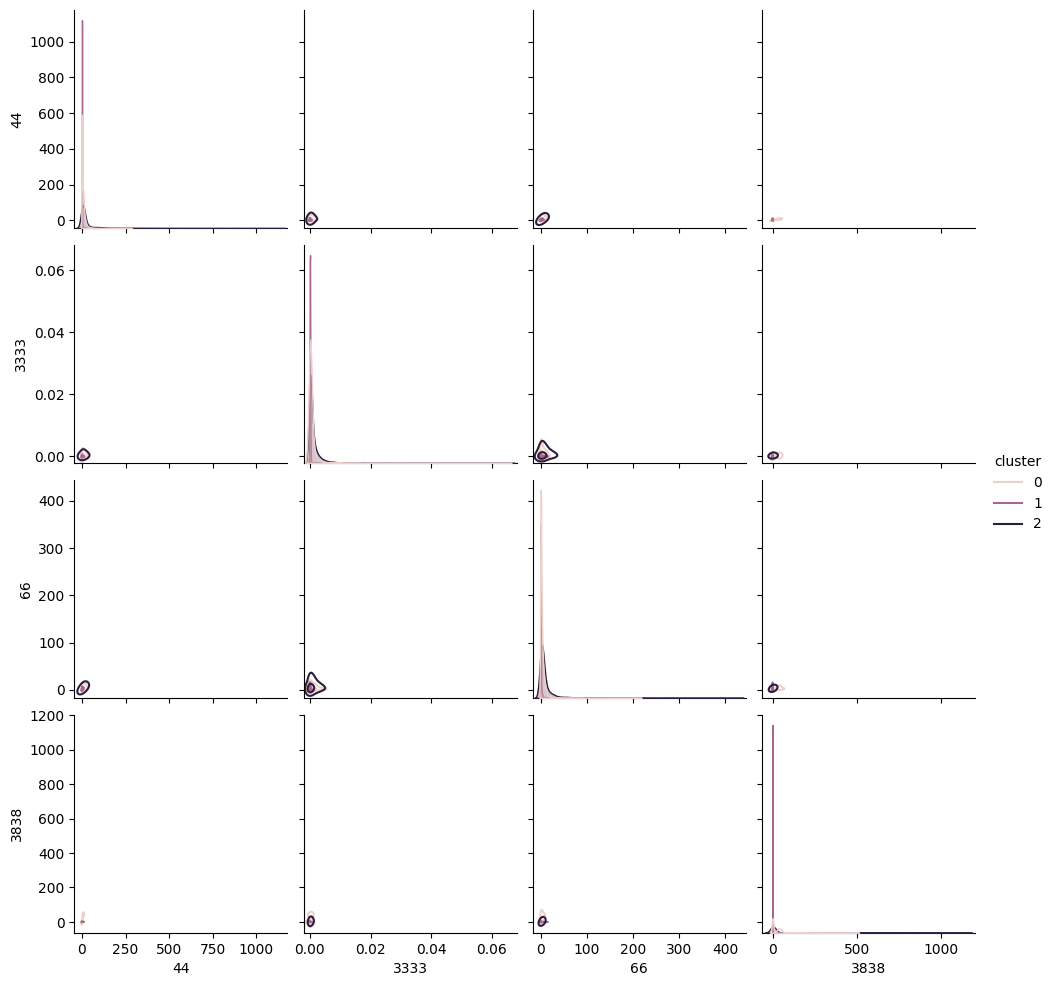

In [13]:
selected_columns = ['cluster', 44, 3333, 66, 3838]
pamap_copy = pamap[selected_columns].copy()
# column_mapping = {
#     'cluster': 'cluster',
#     4: 'acceleration',
#     33: '',
#     6: 'acceleration',
#     38: ''
# }

# pamap_copy = pamap_copy.rename(columns=column_mapping)
sns.pairplot(pamap_copy,hue='cluster',kind='kde') 

In [23]:
X = pamap.drop(['cluster',0,54], axis=1)
y = pamap['cluster']
X.head()

,2,3,4,5,6,7,8,9,10,11,...,44,45,46,47,48,49,50,51,52,53
0,139.0,24.910937,-8.774862,2.921167,2.307146,-8.836571,2.969285,2.242165,-0.010192,-0.043375,...,0.025054,0.072855,0.327494,-44.677669,-7.026946,3.250370,0.555624,-0.316755,0.718974,-0.268680
1,138.0,24.937500,-8.884371,3.639173,2.511493,-8.938693,3.706951,2.457878,0.055468,-0.006314,...,0.004657,-0.017115,0.011002,-45.354818,-3.942657,2.595037,0.544582,-0.304127,0.717182,-0.310576
2,138.0,24.901250,-7.953692,4.918869,1.920328,-8.051530,4.957867,1.866055,1.219631,-0.581240,...,0.251467,-0.058381,-0.167615,-44.676414,-7.139982,3.829399,0.530612,-0.356835,0.695447,-0.324372
3,138.0,24.937500,-6.550635,10.524657,0.379089,-6.833505,10.539075,0.278329,1.171546,-0.321056,...,-0.264943,-0.043607,0.077041,-41.828461,-15.475105,9.590448,0.485194,-0.476597,0.661950,-0.308362
4,138.0,24.937500,-2.638427,8.896337,-2.473392,-2.795023,9.151476,-2.623773,0.876137,0.265966,...,0.260470,-0.071397,-0.150778,-39.629503,-19.076338,12.213491,0.469625,-0.529871,0.628705,-0.304908


In [109]:
# remove highly correlated features 
correlation_matrix = X.corr()
high_corr_threshold = 0.90  # Adjust as needed
correlated_features = set()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > high_corr_threshold:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

print(f'Correlated Features: {correlated_features}')
X = X.drop(columns=correlated_features)
X.head()

Correlated Features: {36, 7, 8, 9, 41, 42, 43, 24, 25, 26}


,2,3,4,5,6,10,11,12,13,14,...,44,45,46,47,48,49,50,51,52,53
0,139.0,24.910937,-8.774862,2.921167,2.307146,-0.010192,-0.043375,0.082578,50.871047,3.529991,...,0.025054,0.072855,0.327494,-44.677669,-7.026946,3.250370,0.555624,-0.316755,0.718974,-0.268680
1,138.0,24.937500,-8.884371,3.639173,2.511493,0.055468,-0.006314,-0.138201,49.099500,5.299573,...,0.004657,-0.017115,0.011002,-45.354818,-3.942657,2.595037,0.544582,-0.304127,0.717182,-0.310576
2,138.0,24.901250,-7.953692,4.918869,1.920328,1.219631,-0.581240,0.740793,43.733028,-10.409996,...,0.251467,-0.058381,-0.167615,-44.676414,-7.139982,3.829399,0.530612,-0.356835,0.695447,-0.324372
3,138.0,24.937500,-6.550635,10.524657,0.379089,1.171546,-0.321056,0.531600,6.255278,-32.256336,...,-0.264943,-0.043607,0.077041,-41.828461,-15.475105,9.590448,0.485194,-0.476597,0.661950,-0.308362
4,138.0,24.937500,-2.638427,8.896337,-2.473392,0.876137,0.265966,0.620075,10.892727,-40.506217,...,0.260470,-0.071397,-0.150778,-39.629503,-19.076338,12.213491,0.469625,-0.529871,0.628705,-0.304908


# XGBoost

In [136]:
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
importance_scores = []


# Initialize XGBoost classifier (you may need to tune hyperparameters)
xgb_classifier = XGBClassifier()

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)  # You can adjust the number of splits as needed

# Loop through each fold and train the XGBoost classifier
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the XGBoost classifier
    xgb_classifier.fit(X_train, y_train)
    importance_scores.append(xgb_classifier.feature_importances_)

    # plot_importance(xgb_classifier, max_num_features=10) # top 10 most important features
    # pyplot.show()  

    # Make predictions on the test set
    predictions = xgb_classifier.predict(X_test)

    conf_matrix = confusion_matrix(y_test, predictions)
    conf_df = pd.DataFrame(conf_matrix, index=range(conf_matrix.shape[0]), columns=range(conf_matrix.shape[1]))
    print(conf_df)


    # Evaluate model
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average=None, zero_division=np.nan)
    recall = recall_score(y_test, predictions, average=None, zero_division=np.nan)
    f1 = f1_score(y_test, predictions, average=None, zero_division=np.nan)

    if len(precision) < len(np.unique(y)):
        for cluster in np.unique(y):
            if cluster not in np.unique(y_test):

                # Find the index where the missing cluster should be inserted
                index_to_insert = np.where(np.unique(y) == cluster)[0][0]
                print(f'No cluster {cluster}. To insert NaN in index {index_to_insert}')

                # Insert nan as a placeholder element in precision, recall, and f1 scores
                precision = np.insert(precision, index_to_insert, np.nan)
                recall = np.insert(recall, index_to_insert, np.nan)
                f1 = np.insert(f1, index_to_insert, np.nan)


    # Append metrics for this fold
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

avg_feat_importance = np.mean(importance_scores, axis=0)

# Calculate average metrics across all folds
avg_accuracy = np.nanmean(accuracy_scores)
avg_precision = np.nanmean(precision_scores, axis=0)
avg_recall = np.nanmean(recall_scores, axis=0)
avg_f1 = np.nanmean(f1_scores, axis=0)

print(f"\nAverage Accuracy: {avg_accuracy}")
print(f"Average Precision: {avg_precision}")
print(f"Average Recall: {avg_recall}")
print(f"Average F1 Score: {avg_f1}")



      0     1  2
0  2725     2  0
1   128  1403  0
2   160     2  0
      0    1    2
0   368    0    0
1   147  215    0
2  3036  215  439
     0   1     2
0  316  15  1259
1    0   0     0
2  232   2  2596
      0    1
0  3516  319
1   278  307
No cluster 1. To insert 1 in index 1
      0     1
0   811   297
1  1489  1823
No cluster 1. To insert 1 in index 1

Average Accuracy: 0.6569683257918553
Average Precision: [0.57280489 0.49905236 0.75593304]
Average Recall: [0.76935539 0.75515858 0.42229874]
Average F1 Score: [0.56611373 0.74900039 0.54188328]


In [137]:
sorted_idx = np.argsort(avg_feat_importance)[::-1]
print(sorted_idx)

[ 2 25  4 29 28 23 17 10 18 13 22 35 39 16  1 41  9 15 30 24 37 11  0 36
 14  3 21 27 38  8 40 20 26 12 31 32  7 19 33  6 34  5]


In [121]:
feature_names = X.columns.tolist()
selected_feature_names = [feature_names[i] for i in sorted_idx[:20]]
print(selected_feature_names)

[4, 33, 6, 38, 37, 31, 22, 15, 23, 18, 30, 47, 51, 21, 3, 53, 14, 20, 39, 32]


In [115]:
np.sort(avg_feat_importance)[::-1]

array([0.10782872, 0.10614178, 0.08156272, 0.06665341, 0.05209284,
       0.05057908, 0.05029033, 0.04803849, 0.04411913, 0.04317421,
       0.0274117 , 0.02678045, 0.02649922, 0.02509029, 0.02292726,
       0.02287461, 0.02266389, 0.01735174, 0.01438552, 0.01391426,
       0.01378562, 0.01336121, 0.01297319, 0.01273522, 0.01113205,
       0.00978691, 0.0073453 , 0.00704006, 0.00694315, 0.00547254,
       0.00527425, 0.0048409 , 0.00465928, 0.00377249, 0.00326214,
       0.00159541, 0.00136968, 0.00094322, 0.0009187 , 0.00088557,
       0.00088343, 0.00064008], dtype=float32)

In [27]:
X_train.shape

(22103, 52)

In [29]:
y_train

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [33]:
import xgboost as xgb
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
importance_scores = []


# Initialize XGBoost classifier (you may need to tune hyperparameters)
# xgb_classifier = XGBClassifier()

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)  # You can adjust the number of splits as needed

# Loop through each fold and train the XGBoost classifier
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # # Train the XGBoost classifier
    # xgb_classifier.fit(X_train, y_train)
    # importance_scores.append(xgb_classifier.feature_importances_)

    # # plot_importance(xgb_classifier, max_num_features=10) # top 10 most important features
    # # pyplot.show()  

    # # Make predictions on the test set
    # predictions = xgb_classifier.predict(X_test)


    params = {"objective": "multi:softmax", "num_class": 3}

    # Create regression matrices
    dtrain_reg = xgb.DMatrix(X_train, y_train)
    dtest_reg = xgb.DMatrix(X_test)

    n = 10000
    model = xgb.train(
        params=params,
        dtrain=dtrain_reg,
        num_boost_round=n,

    )

    y_train_pred = model.predict(dtrain_reg)
    y_test_pred = model.predict(dtest_reg)

    print(y_test)
    print(y_test_pred)

    conf_matrix = confusion_matrix(y_test, y_test_pred)
    conf_df = pd.DataFrame(conf_matrix, index=range(conf_matrix.shape[0]), columns=range(conf_matrix.shape[1]))
    print(conf_df)


    # Evaluate model
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred, average=None, zero_division=np.nan)
    recall = recall_score(y_test, y_test_pred, average=None, zero_division=np.nan)
    f1 = f1_score(y_test, y_test_pred, average=None, zero_division=np.nan)

    if len(precision) < len(np.unique(y)):
        for cluster in np.unique(y):
            if cluster not in np.unique(y_test):

                # Find the index where the missing cluster should be inserted
                index_to_insert = np.where(np.unique(y) == cluster)[0][0]
                print(f'No cluster {cluster}. To insert NaN in index {index_to_insert}')

                # Insert nan as a placeholder element in precision, recall, and f1 scores
                precision = np.insert(precision, index_to_insert, np.nan)
                recall = np.insert(recall, index_to_insert, np.nan)
                f1 = np.insert(f1, index_to_insert, np.nan)


    # Append metrics for this fold
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

avg_feat_importance = np.mean(importance_scores, axis=0)

# Calculate average metrics across all folds
avg_accuracy = np.nanmean(accuracy_scores)
avg_precision = np.nanmean(precision_scores, axis=0)
avg_recall = np.nanmean(recall_scores, axis=0)
avg_f1 = np.nanmean(f1_scores, axis=0)

print(f"\nAverage Accuracy: {avg_accuracy}")
print(f"Average Precision: {avg_precision}")
print(f"Average Recall: {avg_recall}")
print(f"Average F1 Score: {avg_f1}")



4423    0
4424    1
4425    1
4426    0
4427    0
       ..
8838    0
8839    0
8840    0
8841    2
8842    0
Name: cluster, Length: 4420, dtype: int64
[0. 1. 1. ... 0. 0. 0.]
      0     1  2
0  2721     6  0
1   183  1348  0
2   161     1  0
8843     0
8844     0
8845     2
8846     2
8847     0
        ..
13258    2
13259    2
13260    2
13261    2
13263    2
Name: cluster, Length: 4420, dtype: int64
[0. 0. 2. ... 0. 0. 0.]
      0    1    2
0   368    0    0
1   128  234    0
2  2800  487  403
13264    2
13265    2
13266    2
13267    2
13269    2
        ..
18361    0
18362    0
18363    0
18364    0
18365    0
Name: cluster, Length: 4420, dtype: int64
[2. 2. 2. ... 2. 2. 2.]
     0   1     2
0  344  43  1203
1    0   0     0
2  284   2  2544
18366    2
18367    0
18368    0
18371    2
18372    0
        ..
22935    0
22936    0
22937    0
22938    0
22939    0
Name: cluster, Length: 4420, dtype: int64
[2. 0. 0. ... 0. 0. 2.]
      0    1
0  3526  309
1   271  314
No cluster 1. To

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [26]:
import xgboost as xgb
params = {"objective": "multi:softprob", "num_class": 3}
#evals = [(dtest_reg, "validation"), (dtrain_reg, "train")]


print("="*30)
#print(f"Performing XGBoost for selected features: {features}")

# Create regression matrices
dtrain_reg = xgb.DMatrix(X_train, y_train)
dtest_reg = xgb.DMatrix(X_test)

n = 10000
model = xgb.train(
    params=params,
    dtrain=dtrain_reg,
    num_boost_round=n,

)

y_train_pred = model.predict(dtrain_reg)
y_test_pred = model.predict(dtest_reg)

XGBoostError: [21:53:44] /Users/runner/work/xgboost/xgboost/include/xgboost/objective.h:104: multioutput is not supported by current objective function
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000147204994 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001473ac3e8 xgboost::ObjFunction::Targets(xgboost::MetaInfo const&) const + 84
  [bt] (2) 3   libxgboost.dylib                    0x000000014735c050 xgboost::LearnerConfiguration::ConfigureTargets() + 368
  [bt] (3) 4   libxgboost.dylib                    0x0000000147359d64 xgboost::LearnerConfiguration::ConfigureModelParamWithoutBaseScore() + 28
  [bt] (4) 5   libxgboost.dylib                    0x000000014734c1bc xgboost::LearnerConfiguration::Configure() + 1060
  [bt] (5) 6   libxgboost.dylib                    0x000000014734c4b0 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (6) 7   libxgboost.dylib                    0x0000000147224ea4 XGBoosterUpdateOneIter + 144
  [bt] (7) 8   libffi.dylib                        0x00000001a0097050 ffi_call_SYSV + 80
  [bt] (8) 9   libffi.dylib                        0x00000001a009fadc ffi_call_int + 1208



In [142]:
# Train only on top features
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

top_features_indices = sorted_idx[:20]
top_features = X.iloc[:, top_features_indices]



# Initialize XGBoost classifier (you may need to tune hyperparameters)
xgb_classifier = XGBClassifier()

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)  # You can adjust the number of splits as needed

# Loop through each fold and train the XGBoost classifier
for train_index, test_index in tscv.split(top_features):
    X_train, X_test = top_features.iloc[train_index], top_features.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the XGBoost classifier
    xgb_classifier.fit(X_train, y_train)
    #importance_scores.append(xgb_classifier.feature_importances_)

    # plot_importance(xgb_classifier, max_num_features=10) # top 10 most important features
    # pyplot.show()  

    # Make predictions on the test set
    predictions = xgb_classifier.predict(X_test)

    conf_matrix = confusion_matrix(y_test, predictions)
    conf_df = pd.DataFrame(conf_matrix, index=range(conf_matrix.shape[0]), columns=range(conf_matrix.shape[1]))
    print(conf_df)


    # Evaluate model
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average=None, zero_division=np.nan)
    recall = recall_score(y_test, predictions, average=None, zero_division=np.nan)
    f1 = f1_score(y_test, predictions, average=None, zero_division=np.nan)

    if len(precision) < len(np.unique(y)):
        for cluster in np.unique(y):
            if cluster not in np.unique(y_test):

                # Find the index where the missing cluster should be inserted
                index_to_insert = np.where(np.unique(y) == cluster)[0][0]
                print(f'No cluster {cluster}. To insert NaN in index {index_to_insert}')

                # Insert nan as a placeholder element in precision, recall, and f1 scores
                precision = np.insert(precision, index_to_insert, np.nan)
                recall = np.insert(recall, index_to_insert, np.nan)
                f1 = np.insert(f1, index_to_insert, np.nan)


    # Append metrics for this fold
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

avg_feat_importance = np.mean(importance_scores, axis=0)

# Calculate average metrics across all folds
avg_accuracy = np.nanmean(accuracy_scores)
avg_precision = np.nanmean(precision_scores, axis=0)
avg_recall = np.nanmean(recall_scores, axis=0)
avg_f1 = np.nanmean(f1_scores, axis=0)

print(f"\nAverage Accuracy: {avg_accuracy}")
print(f"Average Precision: {avg_precision}")
print(f"Average Recall: {avg_recall}")
print(f"Average F1 Score: {avg_f1}")



      0     1  2
0  2726     1  0
1   249  1282  0
2   153     9  0
      0    1    2
0   368    0    0
1   223  139    0
2  2930  311  449
     0   1     2
0  752  13   825
1    0   0     0
2  492  58  2280
      0   1    2
0  3454   0  381
1     0   0    0
2   126  11  448
      0    1     2
0   810    6   292
1     0    0     0
2  1071  132  2109

Average Accuracy: 0.6704524886877828
Average Precision: [0.59518545 0.26022979 0.78827341]
Average Recall: [0.82085762 0.61066955 0.46598425]
Average F1 Score: [0.62494654 0.62530908 0.5893159 ]


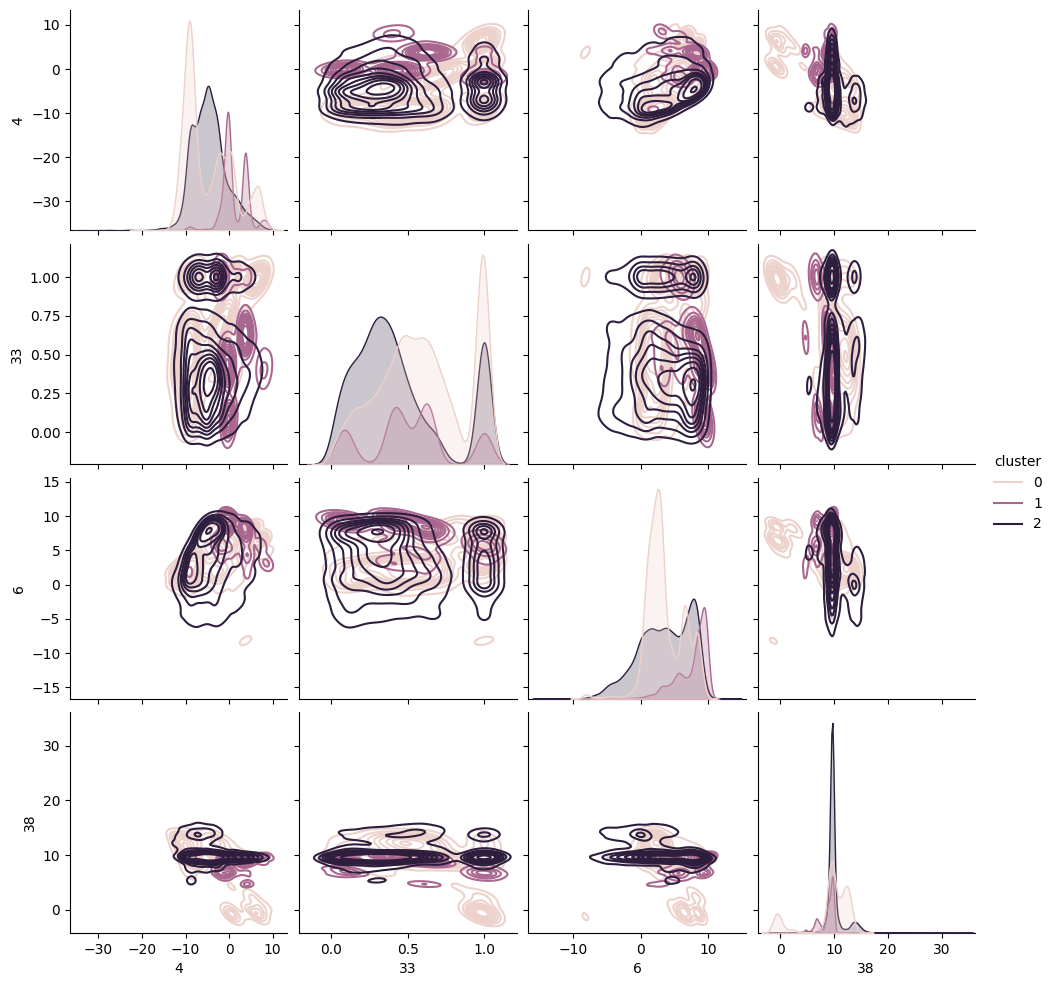

In [143]:
selected_columns = ['cluster', 4, 33, 6, 38]
pamap_copy = pamap[selected_columns].copy()
# column_mapping = {
#     'cluster': 'cluster',
#     4: 'acceleration',
#     33: '',
#     6: 'acceleration',
#     38: ''
# }

# pamap_copy = pamap_copy.rename(columns=column_mapping)
sns.pairplot(pamap_copy,hue='cluster',kind='kde') 


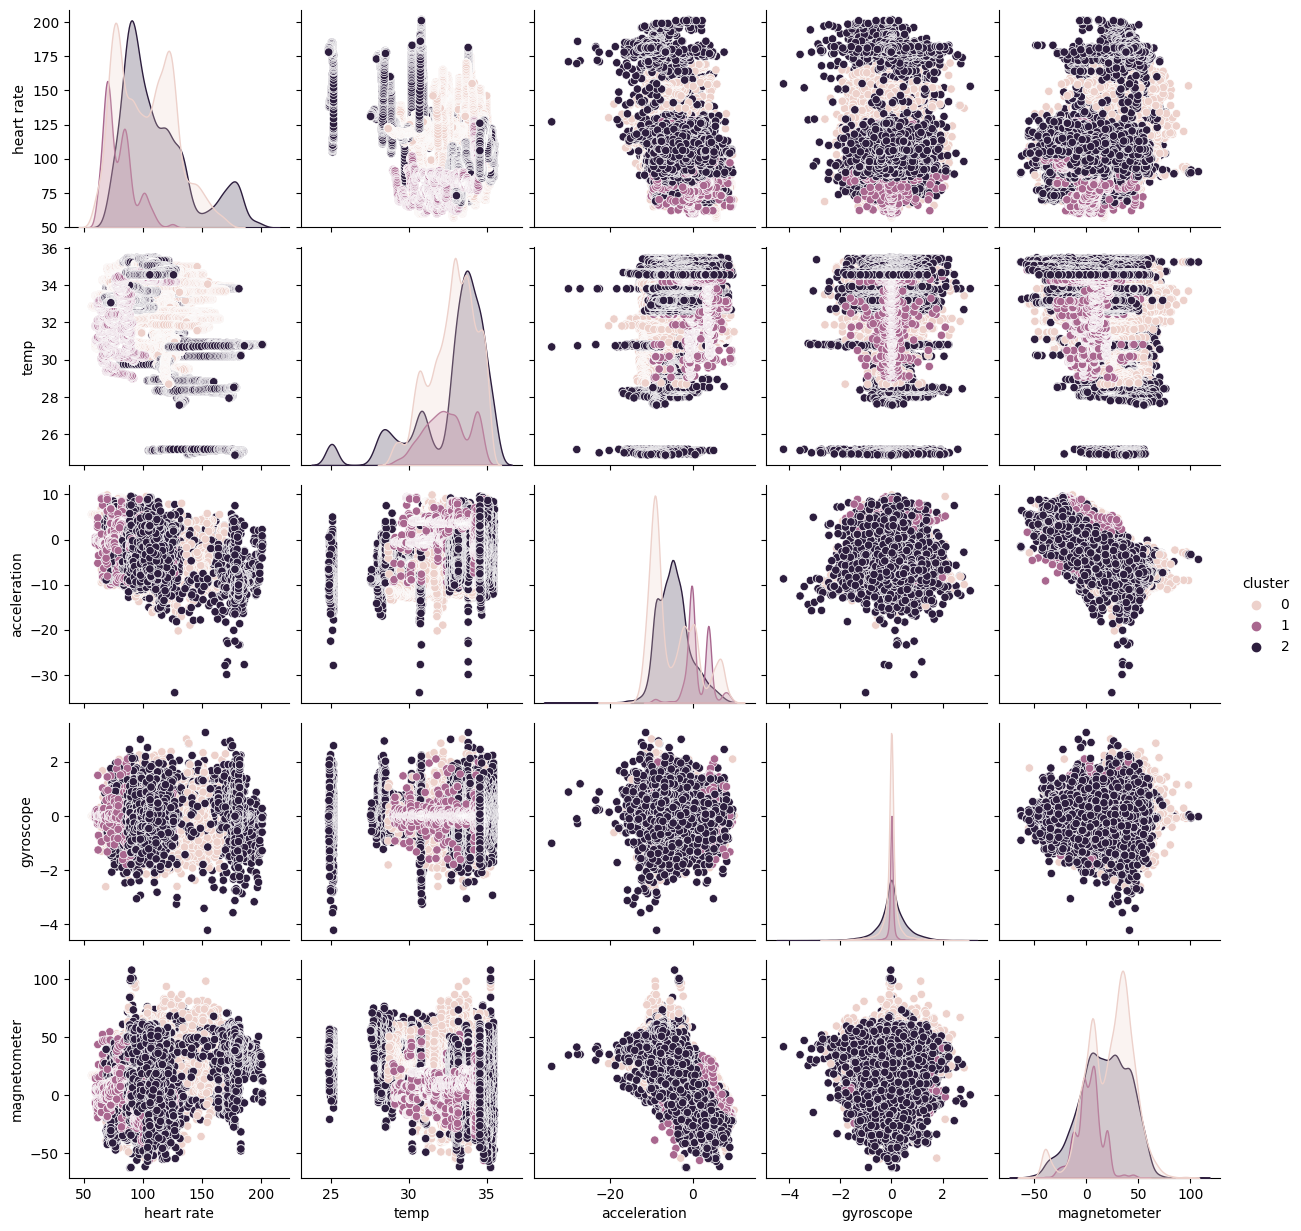

# SVM

In [144]:
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Initialize SVM classifier (you may need to tune hyperparameters)
svm_classifier = SVC()

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)  # You can adjust the number of splits as needed

# Loop through each fold and train the SVM classifier
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the SVM classifier
    svm_classifier.fit(X_train, y_train)

    # Make predictions on the test set
    predictions = svm_classifier.predict(X_test)

    # Evaluate model
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average=None, zero_division=np.nan)
    recall = recall_score(y_test, predictions, average=None, zero_division=np.nan)
    f1 = f1_score(y_test, predictions, average=None, zero_division=np.nan)

    if len(precision) < len(np.unique(y)):
        for cluster in np.unique(y):
            if cluster not in np.unique(y_test):

                # Find the index where the missing cluster should be inserted
                index_to_insert = np.where(np.unique(y) == cluster)[0][0]
                print(f'No cluster {cluster}. To insert NaN in index {index_to_insert}')

                # Insert nan as a placeholder element in precision, recall, and f1 scores
                precision = np.insert(precision, index_to_insert, np.nan)
                recall = np.insert(recall, index_to_insert, np.nan)
                f1 = np.insert(f1, index_to_insert, np.nan)

    # Append metrics for this fold
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

# Calculate average metrics across all folds
avg_accuracy = np.mean(accuracy_scores)
avg_precision = np.nanmean(precision_scores, axis=0)
avg_recall = np.nanmean(recall_scores, axis=0)
avg_f1 = np.nanmean(f1_scores, axis=0)

print(f"\nAverage Accuracy: {avg_accuracy}")
print(f"Average Precision: {avg_precision}")
print(f"Average Recall: {avg_recall}")
print(f"Average F1 Score: {avg_f1}")


No cluster 1. To insert NaN in index 1

Average Accuracy: 0.6528054298642534
Average Precision: [0.59065934 0.26426704 0.73492971]
Average Recall: [0.69616901 0.97126693 0.48586965]
Average F1 Score: [0.57466716 0.62562284 0.54834661]


# CatBoost

In [147]:
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Initialize CatBoost classifier (you may need to tune hyperparameters)
catboost_classifier = CatBoostClassifier()

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)  # You can adjust the number of splits as needed

# Loop through each fold and train the CatBoost classifier
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the CatBoost classifier
    catboost_classifier.fit(X_train, y_train)

    # Make predictions on the test set
    predictions = catboost_classifier.predict(X_test)

    # Evaluate model
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average=None, zero_division=np.nan)
    recall = recall_score(y_test, predictions, average=None, zero_division=np.nan)
    f1 = f1_score(y_test, predictions, average=None, zero_division=np.nan)

    if len(precision) < len(np.unique(y)):
        for cluster in np.unique(y):
            if cluster not in np.unique(y_test):

                # Find the index where the missing cluster should be inserted
                index_to_insert = np.where(np.unique(y) == cluster)[0][0]
                print(f'No cluster {cluster}. To insert NaN in index {index_to_insert}')

                # Insert nan as a placeholder element in precision, recall, and f1 scores
                precision = np.insert(precision, index_to_insert, np.nan)
                recall = np.insert(recall, index_to_insert, np.nan)
                f1 = np.insert(f1, index_to_insert, np.nan)

    # Append metrics for this fold
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

# Calculate average metrics across all folds
avg_accuracy = np.mean(accuracy_scores)
avg_precision = np.nanmean(precision_scores, axis=0)
avg_recall = np.nanmean(recall_scores, axis=0)
avg_f1 = np.nanmean(f1_scores, axis=0)

print(f"\nAverage Accuracy: {avg_accuracy}")
print(f"Average Precision: {avg_precision}")
print(f"Average Recall: {avg_recall}")
print(f"Average F1 Score: {avg_f1}")


Learning rate set to 0.08536
0:	learn: 0.9541001	total: 64.9ms	remaining: 1m 4s
1:	learn: 0.8349075	total: 70.7ms	remaining: 35.3s
2:	learn: 0.7441559	total: 76.7ms	remaining: 25.5s
3:	learn: 0.6645909	total: 82.6ms	remaining: 20.6s
4:	learn: 0.5960000	total: 88.3ms	remaining: 17.6s
5:	learn: 0.5351109	total: 95.1ms	remaining: 15.7s
6:	learn: 0.4846749	total: 101ms	remaining: 14.3s
7:	learn: 0.4386638	total: 109ms	remaining: 13.5s
8:	learn: 0.3988175	total: 119ms	remaining: 13.1s
9:	learn: 0.3637188	total: 130ms	remaining: 12.8s
10:	learn: 0.3316128	total: 140ms	remaining: 12.6s
11:	learn: 0.3022296	total: 151ms	remaining: 12.4s
12:	learn: 0.2773996	total: 159ms	remaining: 12.1s
13:	learn: 0.2546845	total: 167ms	remaining: 11.7s
14:	learn: 0.2341009	total: 177ms	remaining: 11.6s
15:	learn: 0.2161013	total: 184ms	remaining: 11.3s
16:	learn: 0.2001825	total: 191ms	remaining: 11.1s
17:	learn: 0.1846310	total: 200ms	remaining: 10.9s
18:	learn: 0.1699364	total: 209ms	remaining: 10.8s
19:	le

# Other Models

In [148]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [152]:
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Initialize CatBoost classifier (you may need to tune hyperparameters)
classifier = KNeighborsClassifier()

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)  # You can adjust the number of splits as needed

# Loop through each fold and train the CatBoost classifier
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the CatBoost classifier
    classifier.fit(X_train, y_train)

    # Make predictions on the test set
    predictions = classifier.predict(X_test)

    # Evaluate model
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average=None, zero_division=np.nan)
    recall = recall_score(y_test, predictions, average=None, zero_division=np.nan)
    f1 = f1_score(y_test, predictions, average=None, zero_division=np.nan)

    if len(precision) < len(np.unique(y)):
        for cluster in np.unique(y):
            if cluster not in np.unique(y_test):

                # Find the index where the missing cluster should be inserted
                index_to_insert = np.where(np.unique(y) == cluster)[0][0]
                print(f'No cluster {cluster}. To insert NaN in index {index_to_insert}')

                # Insert nan as a placeholder element in precision, recall, and f1 scores
                precision = np.insert(precision, index_to_insert, np.nan)
                recall = np.insert(recall, index_to_insert, np.nan)
                f1 = np.insert(f1, index_to_insert, np.nan)

    # Append metrics for this fold
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

# Calculate average metrics across all folds
avg_accuracy = np.mean(accuracy_scores)
avg_precision = np.nanmean(precision_scores, axis=0)
avg_recall = np.nanmean(recall_scores, axis=0)
avg_f1 = np.nanmean(f1_scores, axis=0)

print(f"\nAverage Accuracy: {avg_accuracy}")
print(f"Average Precision: {avg_precision}")
print(f"Average Recall: {avg_recall}")
print(f"Average F1 Score: {avg_f1}")



Average Accuracy: 0.6762443438914026
Average Precision: [0.60769438 0.23058545 0.73055995]
Average Recall: [0.73931693 0.9860859  0.51121554]
Average F1 Score: [0.59288935 0.69247406 0.60525035]


# NN

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import to_categorical

In [7]:
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Convert labels to one-hot encoding
y_categorical = to_categorical(y)

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)  # You can adjust the number of splits as needed

# Loop through each fold and train the neural network
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_categorical[train_index], y_categorical[test_index]

    num_neurons = X_train.shape[1] * (2/3) + y_categorical.shape[1]

    # Build a simple dense neural network
    model = Sequential()
    model.add(Dense(32, input_dim=X_train.shape[1], activation='tanh'))
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(y_categorical.shape[1], activation='softmax'))  # Use softmax for multiclass classification

    # Compile the model
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

    # Make predictions on the test set
    predictions = np.argmax(model.predict(X_test), axis=1)

    # Evaluate model
    accuracy = accuracy_score(np.argmax(y_test, axis=1), predictions)
    precision = precision_score(np.argmax(y_test, axis=1), predictions, average='weighted', zero_division=np.nan)
    recall = recall_score(np.argmax(y_test, axis=1), predictions, average='weighted', zero_division=np.nan)
    f1 = f1_score(np.argmax(y_test, axis=1), predictions, average='weighted', zero_division=np.nan)

    # Append metrics for this fold
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

# Calculate average metrics across all folds
avg_accuracy = np.nanmean(accuracy_scores)
avg_precision = np.nanmean(precision_scores)
avg_recall = np.nanmean(recall_scores)
avg_f1 = np.nanmean(f1_scores)

print(f"\nAverage Accuracy: {avg_accuracy}")
print(f"Average Precision: {avg_precision}")
print(f"Average Recall: {avg_recall}")
print(f"Average F1 Score: {avg_f1}")

139/139 [==============================] - 0s 303us/step

Average Accuracy: 0.6341176470588235
Average Precision: 0.7726713224844056
Average Recall: 0.6341176470588235
Average F1 Score: 0.6417171425378925
